<a href="https://colab.research.google.com/github/KelvinYQC/CS334_project_CAhousing/blob/master/PSWeight_Heart_Catheterization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

References:
*   Data courtesy Vanderbilt: https://hbiostat.org/data/, https://biostat.app.vumc.org/wiki/pub/Main/DataSets/rhc.html
*   PSweight courtesy Duke: https://cran.r-project.org/package=PSweight
*   One of their papers using this dataset: https://arxiv.org/pdf/1404.1785.pdf
* 2012 R markdown using this dataset: http://rstudio-pubs-static.s3.amazonaws.com/8257_c577ba847be34e89b85a326f20b6d6b9.html

In [ ]:
RequireOrInstall <- function(pkg, ...) { pkg <- as.character(substitute(pkg)); require(pkg, character.only=T, ...) || {install.packages(pkg); require(pkg, character.only=T, ...)} }
RequireOrInstall(PSweight) # testing this

Loading required package: PSweight

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘PSweight’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bitops’, ‘gtools’, ‘caTools’, ‘gplots’, ‘ROCR’, ‘data.table’, ‘nnls’, ‘cvAUC’, ‘numDeriv’, ‘gbm’, ‘SuperLearner’


Loading required package: PSweight



[1] TRUE

In [ ]:
d1 <- read.csv( 'https://biostat.app.vumc.org/wiki/pub/Main/DataSets/rhc.csv', stringsAsFactors=T) # using this dataset
head(d1,2)

,X,cat1,cat2,ca,sadmdte,dschdte,dthdte,lstctdte,death,cardiohx,⋯,meta,hema,seps,trauma,ortho,adld3p,urin1,race,income,ptid
,<int>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<fct>,<int>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<dbl>,<fct>,<fct>,<int>
1,1,COPD,NA,Yes,11142,11151,NA,11382,No,0,⋯,No,No,No,No,No,0,NA,white,Under $11k,5
2,2,MOSF w/Sepsis,NA,No,11799,11844,11844,11844,Yes,1,⋯,No,No,Yes,No,No,NA,1437,white,Under $11k,7


In [ ]:
# I'm testing PSweight for dichotomous outcome/exposure, so outcome is death <= 30 days, exposure Swan-Ganz Catheter aka Right Heart Cath
addmargins(table( Exposure=d1$swang1, Outcome=d1$dth30 ))

,No,Yes,Sum
No RHC,2463,1088,3551
RHC,1354,830,2184
Sum,3817,1918,5735


In [ ]:
# drop dates, variables that leak outcome (death <= 180)
colnames(d1)[f.exclude <- grep( '^X$|dte$|death$|d30$|^surv', colnames(d1) )]
d2 <- d1[,-f.exclude]
set.seed(1); itest <- sample( nrow(d2), 0.25*nrow(d2) ); itrain <- (1:nrow(d2))[-itest]
# gbm doesn't like these types, but does factors:
for( i in which(sapply( d2, function(x) class(x)[1] %in% c('character','logical','factor') )) ) d2[[i]] <- addNA(factor(d2[[i]]))
# PSWeight wants a numeric exposure & outcome
d2$swang1 <- as.numeric( d1$swang1 == 'RHC' )
d2$dth30 <- as.numeric( d1$dth30 == 'No' )
sort(sapply( d2[,which(sapply( d2, class ) == 'factor')], nlevels ))

[1] "X"        "sadmdte"  "dschdte"  "dthdte"   "lstctdte" "death"    "surv2md1"
[8] "t3d30"

sex     dnr1     resp     card    neuro    gastr    renal     meta 
       3        3        3        3        3        3        3        3 
    hema     seps   trauma    ortho       ca     race   income     cat2 
       3        3        3        3        4        4        5        7 
ninsclas     cat1 
       7       10

In [ ]:
# glm wants complete data, impute numerics at median:
(i=which(sapply( d2, function(x) class(x) %in% c('integer','numeric') & any(is.na(x)) )))
for( j in names(i) ) d2[is.na(d2[[j]]),j] <- median( d2[[j]], na.rm=T )

adld3p  urin1 
    51     52

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.08316 0.22950 0.36340 0.38287 0.51842 0.86304 

[1] 0.823702

[1] 0.7799463

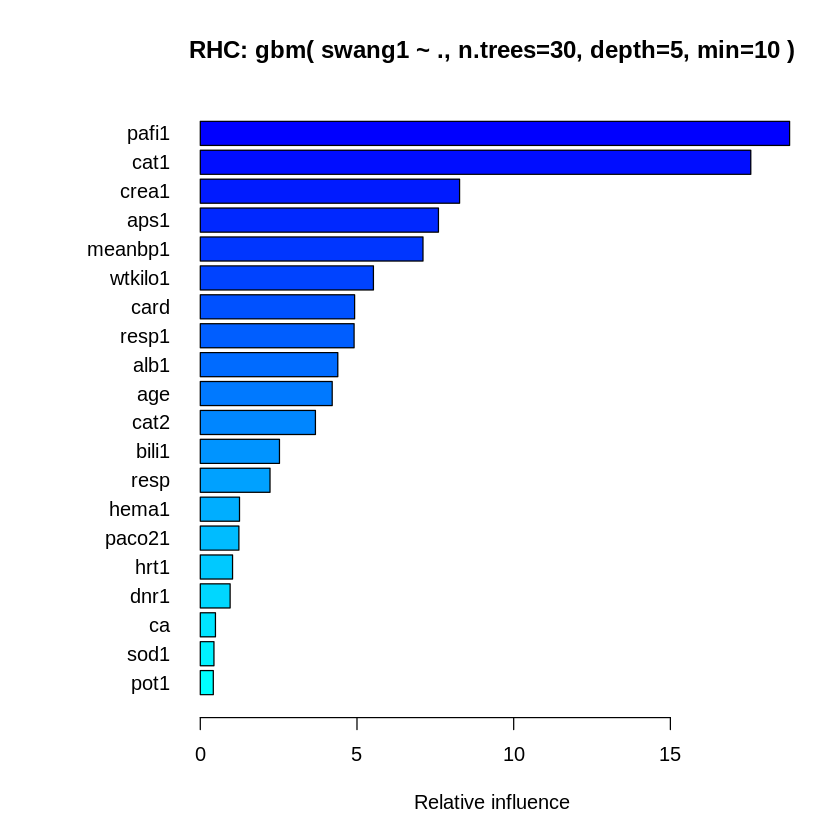

In [ ]:
# try a gbm exposure fit:
set.seed(1); mb1 <- gbm::gbm( swang1 ~ ., data=d2[itrain,], n.trees=30, interaction.depth=5, n.minobsinnode=10, distribution='bernoulli', cv.folds=5 )
summary(mb1.p1 <- predict( mb1, newdata=d2, n.trees=30, type='response' ))
gbm::gbm.roc.area( d2$swang1[itrain], mb1.p1[itrain] ) # 30/5/10=0.824; 10/5/100=0.789; 30/10/100=0.853
gbm::gbm.roc.area( d2$swang1[itest], mb1.p1[itest] ) # 30/5/10=0.780; 10/5/100=0.752; 30/10/100=0.789
par( mfrow=c(1,1), mar=c(5,8,4,2)+0.1 ) # bltr
mb1.imp <- summary( mb1, plotit=T, cBars=20, las=1, main='RHC: gbm( swang1 ~ ., n.trees=30, depth=5, min=10 )' )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.1580  0.5478  0.7089  0.6646  0.8084  0.9153 

[1] 0.8019476

[1] 0.7902039

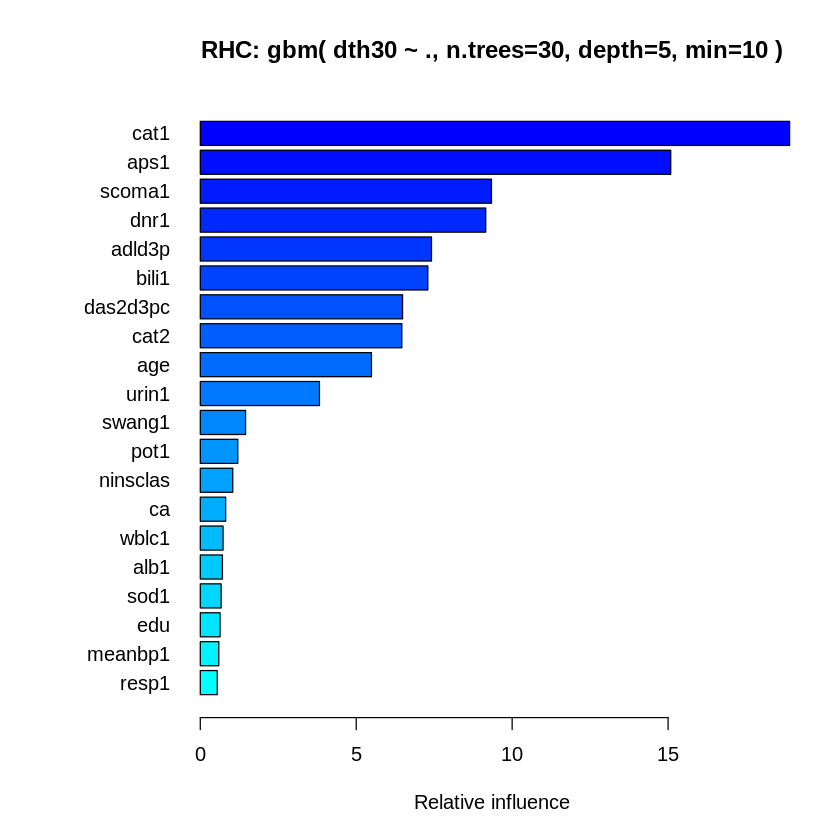

In [ ]:
# try a gbm outcome fit:
set.seed(1); mb2 <- gbm::gbm( dth30 ~ ., data=d2[itrain,], n.trees=30, interaction.depth=5, n.minobsinnode=10, distribution='bernoulli', cv.folds=5 )
summary(mb2.p1 <- predict( mb2, newdata=d2, n.trees=30, type='response' ))
gbm::gbm.roc.area( d2$dth30[itrain], mb2.p1[itrain] ) # 30/5/10=0.802
gbm::gbm.roc.area( d2$dth30[itest], mb2.p1[itest] ) # 30/5/10=0.790
par( mfrow=c(1,1), mar=c(5,8,4,2)+0.1 ) # bltr
mb2.imp <- summary( mb2, plotit=T, cBars=20, las=1, main='RHC: gbm( dth30 ~ ., n.trees=30, depth=5, min=10 )' )

In [ ]:
gbmparams.exposure <- list( n.trees=30, interaction.depth=5, n.minobsinnode=10, distribution='bernoulli', cv.folds=20 )
gbmparams.outcome <- list( n.trees=30, interaction.depth=5, n.minobsinnode=10, distribution='bernoulli', cv.folds=20 )
set.seed(1); summary(ato1 <- PSweight( 
  data=d2, yname='dth30', zname='swang1', 
  ps.formula=swang1 ~ ., method='gbm', ps.control=gbmparams.exposure, 
  out.formula=dth30 ~ ., methodout='gbm', out.control=gbmparams.outcome
))


Closed-form inference: 

Original group value:  0, 1 

Contrast: 
            0 1
Contrast 1 -1 1

            Estimate Std.Error       lwr       upr  Pr(>|z|)    
Contrast 1 -0.055489  0.013735 -0.082408 -0.028569 5.344e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [ ]:
# try using the test set only (avoid the overfit in PSweight?)
set.seed(1); summary(ato1b <- PSweight( 
  data=d2[itest,], yname='dth30', zname='swang1', 
  ps.estimate=mb1.p1[itest], out.estimate=mb2.p1[itest]
))


Closed-form inference: 

Original group value:  0, 1 

Contrast: 
            0 1
Contrast 1 -1 1

            Estimate Std.Error       lwr        upr Pr(>|z|)  
Contrast 1 -0.064181  0.027770 -0.118609 -0.0097526  0.02082 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In https://arxiv.org/pdf/1404.1785.pdf I think they got -0.0594? Their SE was 0.0246. Don't know their parameters; nobody knows right answer.

Try using glm?

In [ ]:
stopifnot( !is.na(d2) )
set.seed(1); summary(ato1 <- PSweight( ps.formula=swang1 ~ ., yname='dth30', data=d2, family='binomial', method='glm' ))
# takes a while, runs, needs some work ...

Warning message in value[[3L]](cond):
“The sandwich matrix not pd, therefore not invertable, use conservative variance instead, please double check”



Closed-form inference: 

Original group value:  0, 1 

Contrast: 
            0 1
Contrast 1 -1 1

            Estimate Std.Error       lwr       upr  Pr(>|z|)    
Contrast 1 -0.067494  0.015055 -0.097002 -0.037987 7.357e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [ ]:
RequireOrInstall(h2o)
h2o.init( nthreads=9, max_mem_size='30g' )

In [ ]:
# use raw d1, at h2o automl defaults for 2 minutes ...
d1h.train <- as.h2o(d1[itrain,-f.exclude]); d1h.test <- as.h2o(d1[itest,-f.exclude]) # h2o indexing finicky
mh1 <- h2o.automl( y='swang1', training_frame=d1h.train, seed=1, stopping_metric='AUC', nfolds=10, max_runtime_secs=2*60 )
mh1@leaderboard # xgboost, 0.81/0.71
summary(mh1.ptrain <- as.data.frame(predict( mh1, d1h.train ))[['RHC']])
summary(mh1.ptest <- as.data.frame(predict( mh1, d1h.test ))[['RHC']])

Warning message in use.package("data.table"):
“data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups.”


  |======================================================================| 100%


Warning message in use.package("data.table"):
“data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups.”


  |======================================================================| 100%
  |======================================================================| 100%


                                             model_id       auc   logloss
1    StackedEnsemble_AllModels_AutoML_20210313_033938 0.8083773 0.5156927
2 StackedEnsemble_BestOfFamily_AutoML_20210313_033938 0.8077105 0.5163063
3          GBM_grid__1_AutoML_20210313_033938_model_1 0.7826712 0.5548943
4 DeepLearning_grid__1_AutoML_20210313_033938_model_1 0.7794893 0.5468326
5      XGBoost_grid__1_AutoML_20210313_033938_model_1 0.7769621 0.5864969
6          GBM_grid__1_AutoML_20210313_033938_model_2 0.7709154 0.5756611
      aucpr mean_per_class_error      rmse       mse
1 0.7081764            0.2665035 0.4147789 0.1720415
2 0.7097630            0.2638957 0.4151165 0.1723217
3 0.6732432            0.2782410 0.4328138 0.1873278
4 0.6646507            0.2950425 0.4297905 0.1847199
5 0.6784025            0.3059533 0.4392574 0.1929471
6 0.6482298            0.2897260 0.4422908 0.1956211

[22 rows x 7 columns] 

  |======================================================================| 100%


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.04629 0.12673 0.29779 0.39247 0.67615 0.94474 

  |======================================================================| 100%


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0485  0.1459  0.3313  0.3862  0.6116  0.9344 

In [ ]:
mh2 <- h2o.automl( y='dth30', training_frame=d1h.train, seed=1, stopping_metric='AUC', nfolds=10, max_runtime_secs=2*60 )
mh2@leaderboard # gbm, 0.81/0.72
summary(mh2.ptrain <- as.data.frame(predict( mh2, d1h.train ))[['No']])
summary(mh2.ptest <- as.data.frame(predict( mh2, d1h.test ))[['No']])

  |=========                                                             |  13%
  |======================================================================| 100%


                                             model_id       auc   logloss
1    StackedEnsemble_AllModels_AutoML_20210313_034312 0.7931414 0.5107281
2 StackedEnsemble_BestOfFamily_AutoML_20210313_034312 0.7924330 0.5113768
3          GBM_grid__1_AutoML_20210313_034312_model_1 0.7900224 0.5167967
4          GBM_grid__1_AutoML_20210313_034312_model_2 0.7639097 0.5453966
5      XGBoost_grid__1_AutoML_20210313_034312_model_3 0.7591001 0.5434613
6      XGBoost_grid__1_AutoML_20210313_034312_model_1 0.7556482 0.6116954
      aucpr mean_per_class_error      rmse       mse
1 0.6459665            0.2773188 0.4120383 0.1697756
2 0.6506517            0.2779684 0.4126870 0.1703106
3 0.6500228            0.2826673 0.4149574 0.1721897
4 0.6035192            0.3017083 0.4288313 0.1838962
5 0.5911293            0.3055364 0.4271380 0.1824468
6 0.6030766            0.3136428 0.4415472 0.1949639

[23 rows x 7 columns] 

  |======================================================================| 100%


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.06353 0.49638 0.73192 0.65775 0.85801 0.94712 

  |======================================================================| 100%


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.08253 0.48131 0.70954 0.64383 0.83101 0.94454 

In [ ]:
set.seed(1); summary(ato1c <- PSweight( 
  data=d2[itest,], yname='dth30', zname='swang1', 
  ps.estimate=mh1.ptest, out.estimate=mh2.ptest
))


Closed-form inference: 

Original group value:  0, 1 

Contrast: 
            0 1
Contrast 1 -1 1

            Estimate Std.Error       lwr      upr Pr(>|z|)
Contrast 1 -0.024532  0.030641 -0.084588 0.035524   0.4234

In [ ]:
h2o.getModel( mh1@leaderboard$model_id[3,1] ) # GBM, 26 trees, 3 deep, 8 max
h2o.getModel( mh2@leaderboard$model_id[3,1] ) # GBM 37 trees, 3 deep, 8 max

  |======================================================================| 100%


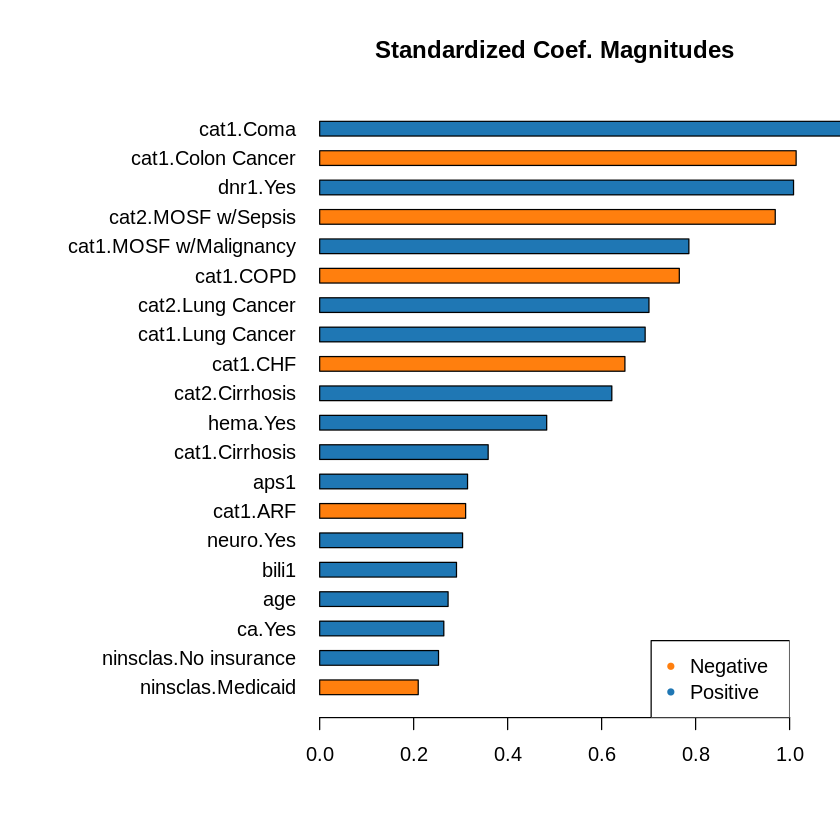

In [ ]:
# try a h2o.glm:
set.seed(1); mh3 <- h2o.glm( y='dth30', training_frame=d1h.train )
h2o.std_coef_plot(model=mh3, num_of_features=20)

In [ ]:
h2o.performance( model=mh3, newdata=d1h.test )
# 0.77/0.64 is decent

H2OBinomialMetrics: glm

MSE:  0.1767807
RMSE:  0.420453
LogLoss:  0.5301468
Mean Per-Class Error:  0.2827316
AUC:  0.7736986
AUCPR:  0.6410848
Gini:  0.5473972
R^2:  0.2120347
Residual Deviance:  1519.401
AIC:  1669.401

Confusion Matrix (vertical: actual; across: predicted) for F1-optimal threshold:
        No Yes    Error       Rate
No     650 296 0.312896   =296/946
Yes    123 364 0.252567   =123/487
Totals 773 660 0.292394  =419/1433

Maximum Metrics: Maximum metrics at their respective thresholds
                        metric threshold      value idx
1                       max f1  0.320746   0.634699 239
2                       max f2  0.139848   0.748560 343
3                 max f0point5  0.455236   0.636364 170
4                 max accuracy  0.455236   0.751570 170
5                max precision  0.978635   1.000000   0
6                   max recall  0.048255   1.000000 393
7              max specificity  0.978635   1.000000   0
8             max absolute_mcc  0.453555   0